In [1]:
!pip install langchain langchain_core langchain-google-genai langgraph pydantic

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [3]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

Enter your Google AI API key: ··········


In [4]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite",
    temperature=0,
)

# Building Blocks: The Augmented LLM

In [5]:
# Schema for structured output
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


In [6]:
# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

In [7]:
output

SearchQuery(search_query='Calcium CT score and high cholesterol relationship', justification='The user is asking about the relationship between Calcium CT score and high cholesterol. This search query directly addresses that relationship.')

In [8]:
# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

In [9]:
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'c90485bd-d371-40c6-9a73-63ebe49c87b3',
  'type': 'tool_call'}]

In [10]:
msg

AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2, "b": 3}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': []}, id='run--b156a047-2839-42af-ac9f-1c3d08a2e5f7-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'c90485bd-d371-40c6-9a73-63ebe49c87b3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 50, 'output_tokens': 18, 'total_tokens': 68, 'input_token_details': {'cache_read': 0}})

# Prompt chaining

In [11]:
from typing_extensions import TypedDict
from langgraph.graph import (
    StateGraph, END, START
)
from IPython.display import Image, Markdown

In [12]:
# Graph stage
class State(TypedDict):
  topic: str
  joke: str
  improved_joke: str
  final_joke: str

In [13]:
# Nodes
def generate_joke(state: State):
  """ First LLM call to generate initial joke"""

  msg = llm.invoke(f"Tell me a joke about {state['topic']}")
  return {'joke': msg.content}

def check_punchline(state: State):
  """ Gate function to check if the joke is a punchline  """

  # Simple check - Does the joke content ! or ?
  if '!' in state['joke'] or '?' in state['joke']:
    return "Pass"
  else:
    return "Fail"

def improve_joke(state: State):
  """ Second LLM call to improve the initial joke"""

  msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
  return {'improved_joke': msg.content}

def polish_joke(state: State):
  """ Third LLM call to polish the joke"""

  msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
  return {'final_joke': msg.content}

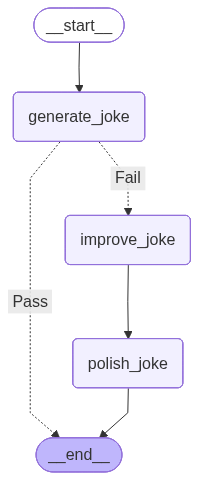

In [14]:
# Build a workflow
workflow = StateGraph(State)

# add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges("generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END})
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# compile
chain = workflow.compile()

# Display workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [15]:
# Invoke
state = chain.invoke({"topic": "Elon"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
Why did Elon Musk break up with his GPS?

Because it kept telling him to "turn left," and he insisted on going "to Mars."

--- --- ---

Joke failed quality gate - no punchline detected!


# Parallelization

In [16]:
# State
class State(TypedDict):
  topic: str
  joke: str
  story: str
  poem: str
  combined_output: str

In [17]:
# Nodes
def call_llm_1(state: State):
  """First LLM call to generate initial joke"""

  msg = llm.invoke(f"Write a joke about {state['topic']}")
  return {"joke": msg.content}


def call_llm_2(state: State):
  """Second LLM call to generate story"""

  msg = llm.invoke(f"Write a story about {state['topic']}")
  return {"story": msg.content}


def call_llm_3(state: State):
  """Third LLM call to generate poem"""

  msg = llm.invoke(f"Write a poem about {state['topic']}")
  return {"poem": msg.content}

# Aggregator
def aggregator(state: State):
  """ Aggragate joke, story, and poem into a single output """

  combined = f"Here is a joke, story, and poem about {state['topic']}!\n\n"
  combined += f"Joke: {state['joke']}\n\n"
  combined += f"Story: {state['story']}\n\n"
  combined += f"Poem: {state['poem']}\n\n"

  return {"combined_output": combined}

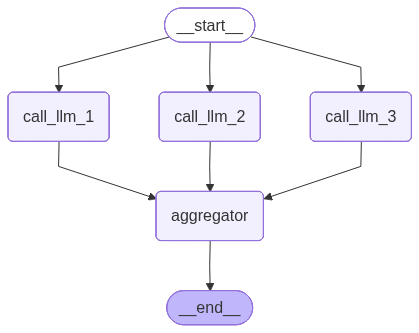

In [18]:
# Build parallel workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")

parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)

# Compile
parallel_workflow = parallel_builder.compile()

#Display Workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))


In [19]:
# Invoke
state = parallel_workflow.invoke({"topic": "Elon"})
print(state["combined_output"])

Here is a joke, story, and poem about Elon!

Joke: Why did Elon Musk break up with his GPS?

Because it kept telling him to "turn left," and he insisted on going to Mars.

Story: The hum of the Tesla was a familiar lullaby to Elon. Not the gentle, sleep-inducing kind, but the low, resonant thrum of contained power, a promise of what was to come. He leaned back in the driver's seat, the soft leather cool against his skin, and watched the California sunset bleed across the horizon. It was a cliché, he knew, but clichés often held a kernel of truth. And tonight, the truth felt particularly potent.

He wasn't driving to a board meeting, or a rocket launch, or even a clandestine rendezvous with a leading AI researcher. Tonight, he was driving to a diner. A greasy spoon, the kind with chipped Formica tables and coffee that tasted like it had been brewed in a forgotten pot. It was a deliberate choice, a conscious shedding of the gilded cage of his usual existence.

The idea had struck him, as

# Routing

In [20]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage

# Schema for structured output to use as routing logic
class Route(BaseModel):
  step: Literal['joke', 'story', 'poem'] = Field(
      None, description="The next step in the routing process"
  )

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

In [22]:
# State
class State(TypedDict):
  input: str
  decision: str
  output: str


# Nodes
def llm_call_1(state: State):
  """Write a story"""

  result = llm.invoke(state["input"])
  return {"output": result.content}


def llm_call_2(state: State):
  """Write a joke"""

  result = llm.invoke(state["input"])
  return {"output": result.content}


def llm_call_3(state: State):
  """Write a poem"""

  result = llm.invoke(state["input"])
  return {"output": result.content}

def llm_call_router(state: State):
  """Route the input to the appropriate node"""

  # Run the augmented LLM with structured output to serve as routing logic
  decision = router.invoke(
      [
          SystemMessage(
            content="Route the input to story, joke, or poem based on the user's request."
          ),
          HumanMessage(content=state["input"]),
      ]
  )

  return {'decision': decision.step}

# Conditional edge function to route to the appropriate node
def route_decision(state: State):
  if state["decision"] == "story":
    return "llm_call_1"
  elif state["decision"] == "joke":
    return "llm_call_2"
  elif state["decision"] == "poem":
    return "llm_call_3"

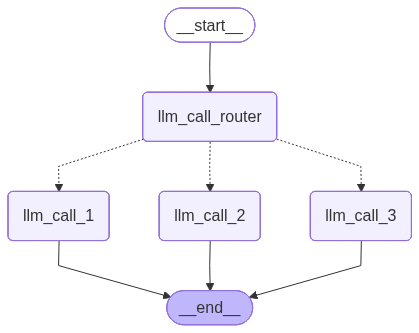

In [24]:
# Build workflow
route_builder = StateGraph(State)

# Add node
route_builder.add_node("llm_call_router", llm_call_router)
route_builder.add_node("llm_call_1", llm_call_1)
route_builder.add_node("llm_call_2", llm_call_2)
route_builder.add_node("llm_call_3", llm_call_3)

# Add edges to connect nodes
route_builder.add_edge(START, "llm_call_router")
route_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3"
    }
)
route_builder.add_edge("llm_call_1", END)
route_builder.add_edge("llm_call_2", END)
route_builder.add_edge("llm_call_3", END)

# compile
routing_workflow =route_builder.compile()

# Display workflow graph
display(Image(routing_workflow.get_graph().draw_mermaid_png()))

In [32]:
# Invoke
state = routing_workflow.invoke({"input": "tell me a joko about Robots"})
print(f"Desion: {state['decision']}\n")
print(f"Output: \n\n{state['output']}")

Desion: joke

Output: 

Why did the robot go to art school?

Because he wanted to learn how to **draw circuits**!


# Orchestrator-Worker

With orchestrator-worker, an orchestrator breaks down a task and delegates each sub-task to workers.

In [33]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
  name: str = Field(
      description="Name for this section of the report.",
  )
  description: str = Field(
      description="Brief overview of the main topics and concepts to be covered in this section.",
  )


class Sections(BaseModel):
  sections: List[Section] = Field(
      description="Sections of the report.",
  )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [43]:
from langgraph.types import Send

class State(TypedDict):
  topic: str # Report topic
  sections: List[Section] # List of report section
  completed_sections: Annotated[
      list, operator.add
  ] # All worker write to this key in parallel
  final_report: str

class WorkerState(TypedDict):
  section: Section
  completed_sections: Annotated[
      list, operator.add
  ] # Only this worker writes to this key

# Nodes
def orchestrator(state: State):
  """Orchestrator that generates a plan for the report"""

  # Generate queries
  report_sections = planner.invoke(
      [
          SystemMessage(content="Generate a plan for the report."),
          HumanMessage(content=f"Here is the topic: {state['topic']}."),
      ]
  )

  return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
  """ Worker write a report of the given section """

  report_section = llm.invoke(
      [
          SystemMessage("Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."),
          HumanMessage(content=f"Name: {state['section'].name}\nDescription: {state['section'].description}"),
      ]
  )

  return {"completed_sections": [report_section.content]}

def synthesizer(state: State):
  """Synthesize full report from sections"""

  # List of completed sections
  completed_sections = state['completed_sections']

  # Combine completed sections
  final_report = "\n\n---\n\n".join(completed_sections)

  return {"final_report": final_report}

# Conditional edge function to create llm_call workers that each write a section of the report
def assign_worker(state: State):
  """Assign a worker to each section in the plan"""

  # Kick off section writing in parallel via Send() API
  return [Send("llm_call", {"section": s}) for s in state["sections"]]

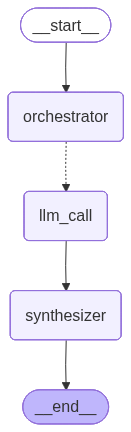

In [44]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Edges connectors
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator",
    assign_worker,
    ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

orchestrator_worker_workflow = orchestrator_worker_builder.compile()

# display workflow graph
display(Image(orchestrator_worker_workflow.get_graph().draw_mermaid_png()))

In [47]:
# invoke
report = orchestrator_worker_workflow.invoke({"topic": "Elon Musk"})

In [48]:
print(report['final_report'])

name='Introduction' description="Overview of Elon Musk's life, career, and major achievements."

--- --- ---

name='Early Life and Education' description="Details about Elon Musk's childhood, upbringing, and educational background."

--- --- ---

name='Career and Ventures' description='Exploration of his involvement in various companies such as Zip2, PayPal, SpaceX, Tesla, Neuralink, and The Boring Company.'

--- --- ---

name='Innovations and Impact' description='Analysis of his contributions to technology, space exploration, and the automotive industry, and their broader impact on society.'

--- --- ---

name='Criticisms and Controversies' description='Discussion of the criticisms and controversies surrounding Elon Musk, including his business practices, public statements, and management style.'

--- --- ---

name='Future Outlook' description="Speculation on Elon Musk's future endeavors and their potential impact on various industries and the world."

--- --- ---

name='Conclusion' d

# Evaluator-optimizer

In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop

In [62]:
# Graph state
class State(TypedDict):
  topic: str
  joke: str
  feedback: str
  funny_or_not: str

class Feedback(BaseModel):
  grade: Literal["funny", "not funny"] = Field(
      description="Decide if the joke is funny or not. It must not a cliché joke. check his originality")
  feedback: str = Field(
      description="If the joke is not funny, provide a feedback on how to improve it.")

evaluator_llm = llm.with_structured_output(Feedback)

In [63]:
def llm_call_generator(state: State):
  """ Generate a joke base on topic and/or feedback"""

  if state.get("feedback"):
    msg = llm.invoke(f"Write a joke about {state['topic']} by considering this feedback : {state['feedback']}")
  else:
    msg = llm.invoke(f"Tell me a joke about {state['topic']}")
  return {"joke": msg.content}

def llm_call_evaluator(state: State):
  """Evaluate the joke"""

  grade = evaluator_llm.invoke(f"grade this joke: {state['joke']}")

  return {"funny_or_not": grade.grade, "feedback": grade.feedback}

def route_joke(state: State):
  """ Get the feedback """

  if state["funny_or_not"] == "funny":
    return "Pass"
  elif state["funny_or_not"] == "not funny":
    return "Fail + Feedback"

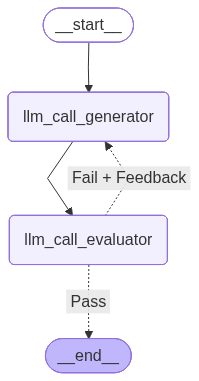

In [64]:
# Build workflow
evaluator_optimizer_builder = StateGraph(State)

# add nodes
evaluator_optimizer_builder.add_node("llm_call_generator", llm_call_generator)
evaluator_optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# add edges
evaluator_optimizer_builder.add_edge(START, "llm_call_generator")
evaluator_optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
evaluator_optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {"Pass": END, "Fail + Feedback": "llm_call_generator"}
)

# compile
evaluator_optimizer_workflow = evaluator_optimizer_builder.compile()

# Display workflow graph
display(Image(evaluator_optimizer_workflow.get_graph().draw_mermaid_png()))

In [67]:
# Invoke
state = evaluator_optimizer_workflow.invoke({'topic': 'Virus'})

print(f"{state['funny_or_not']}\n\n")
print(f"{state['feedback']}\n\n")
print(state['joke'])

funny


The joke is original and humorous. The wordplay on 


Why did the virus break up with the computer?

Because it felt like they were just going through the motions, and it was tired of being *copied*!
